## 0. Requirements 

In [3]:
!pip -q install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [19]:
!pip -q install bioinfokit

In [ ]:
!pip -q install goatools

## 1. Read Human Proteins and Volcano Plot

In [2]:
import pandas as pd

In [24]:
df = pd.read_excel("../data/Human Proteins.xlsx")

In [123]:
print(df.shape)
df.head(3)

(1382, 13)


,Accession Number,GeneNames,Cancer,Cancer.1,Cancer.2,control,control.1,control.2,Average cancer,average control,FC,log2FC,p-value
0,P02768,ALB,1161,1035,971,2897,2911,2997,1055.666667,2935.000000,0.359682,-1.475206,0.000031
1,P02787,TF,1162,1144,1139,2588,2722,2664,1148.333333,2658.000000,0.432029,-1.210800,0.000232
2,P00738,HP,479,493,500,948,988,972,490.666667,969.333333,0.506190,-0.982250,0.000020


In [36]:
# Rename columns
df.rename(columns = {'Alternate ID':'GeneNames','LOg2FC':'log2FC','pvalue':'p-value'}, inplace = True)
# Drop NaN to perform the plots
df.dropna(subset = ['log2FC','p-value'], inplace=True)

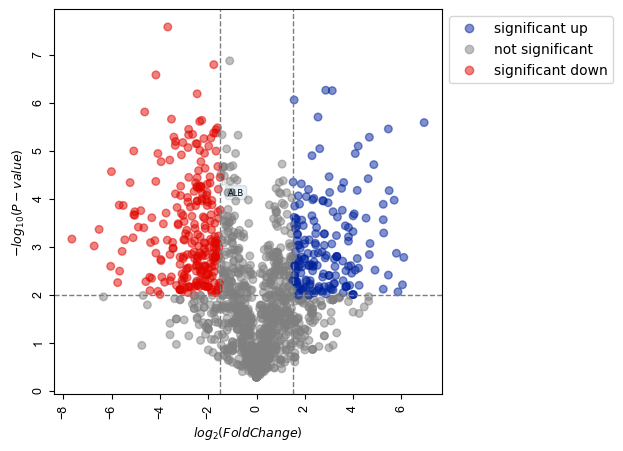

In [87]:
from bioinfokit import analys, visuz
visuz.GeneExpression.volcano(df=df, lfc='log2FC', pv='p-value', lfc_thr=(1.5, 1.5), pv_thr=(0.01, 0.01), 
    color=("#00239CFF", "grey", "#E10600FF"), valpha=0.5, plotlegend=True, legendpos='upper right', 
    legendanchor=(1.46,1), dotsize=30, gstyle=2, sign_line=True,
                            geneid="GeneNames",  genenames=({"ALB":"ALB"}),
                        show=True)

# 2. Get the genes groups

In [88]:
# The top up
top_up = df.loc[(df['log2FC'] > 1.5) & (df['p-value'] < 0.01)]
print(len(top_up['GeneNames'].unique()))
top_up_genes = top_up['GeneNames'].tolist()

179


In [139]:
top_up_genes[:10]

['MYH9',
 'KRT14',
 'KRT6A',
 'KRT6B',
 'KRT5',
 'KRT6C',
 'KRT16',
 'KRT17',
 'LTF',
 'COL12A1']

In [140]:
# The top down
top_down = df.loc[(df['log2FC'] < -1.5) & (df['p-value'] < 0.01)]
print(len(top_down['GeneNames'].unique()))
top_down_genes = top_down['GeneNames'].tolist()
top_down_genes[:10]

252


['HPX', 'C3', 'MYH2', 'APOB', 'ACTN2', 'A2M', 'MYH1', 'MYH7', 'CFH', 'ENO3']

# 3. From Kegg

In [93]:
# Show images inline
from IPython.display import Image

# Standard library packages
import io
import os

# Import Biopython modules to interact with KEGG
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

# Import Pandas, so we can use dataframes
import pandas as pd

In [91]:
word = 'glutamate'

from Bio.KEGG import REST
human_pathways = REST.kegg_list("pathway", "hsa").read()
print(len(human_pathways))

# Filter all human pathways for repair pathways
word_pathways = []
for line in human_pathways.rstrip().split("\n"):
    entry, description = line.split("\t")
    if word in description:
        word_pathways.append(entry)
        print(entry, description)

len(word_pathways)

21034
hsa00250 Alanine, aspartate and glutamate metabolism - Homo sapiens (human)


1

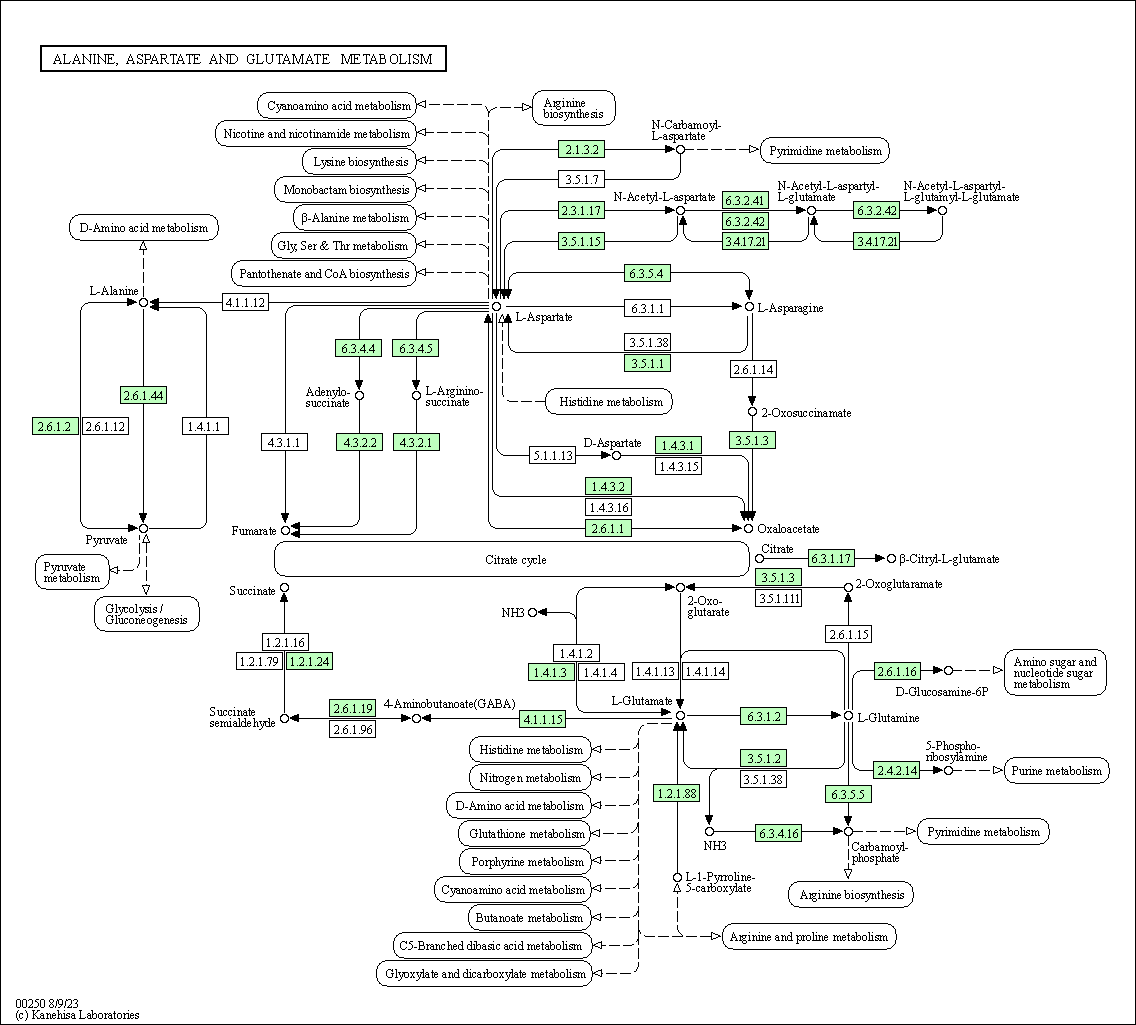

In [94]:
metabolic_pathway_selected = "hsa00250"

# Get map of Pathway in Cancer from H. sapiens
result = REST.kegg_get(metabolic_pathway_selected, "image").read()
Image(result)

In [95]:
# Get the genes for pathways and add them to a list
repair_pathways = [metabolic_pathway_selected]
repair_genes = []
for pathway in repair_pathways:
    pathway_file = REST.kegg_get(pathway).read()  # query and read each pathway

    # iterate through each KEGG pathway file, keeping track of which section
    # of the file we're in, only read the gene in each pathway
    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            gene_identifiers, gene_description = line[12:].split("; ")
            gene_id, gene_symbol = gene_identifiers.split()

            if not gene_symbol in repair_genes:
                repair_genes.append(gene_symbol)

print(
    "There are %d cancer pathways and %d cancer genes. The genes are:"
    % (len(repair_pathways), len(repair_genes))
)
#for gene in repair_genes:
#    print(gene)
print(", ".join(repair_genes))

There are 1 cancer pathways and 37 cancer genes. The genes are:
GOT1, GOT1L1, GOT2, IL4I1, DDO, ASRGL1, ASNS, NIT2, GPT2, GPT, AGXT, AGXT2, ASS1, ASL, ADSS1, ADSS2, ADSL, NAT8L, RIMKLB, RIMKLA, FOLH1, ASPA, GAD1, GAD2, ABAT, ALDH5A1, GLUD2, GLUD1, ALDH4A1, GLUL, CAD, GLS2, GLS, CPS1, GFPT2, GFPT1, PPAT


In [142]:
import pandas as pd
human_proteoma = pd.read_csv("../data/Uniprot/uniprot-human_proteome-2023.06.24.tsv.gz",sep='\t',low_memory=False)
print(human_proteoma.shape)
print(human_proteoma.columns)
human_proteoma.head(3)

(82492, 66)
Index(['Entry', 'Reviewed', 'Entry Name', 'Protein names', 'Gene Names',
       'Organism', 'Length', 'Cofactor', 'Site', 'Active site', 'Absorption',
       'EC number', 'Redox potential', 'Rhea ID', 'Activity regulation',
       'Binding site', 'Catalytic activity', 'DNA binding', 'pH dependence',
       'Pathway', 'Kinetics', 'Function [CC]', 'Temperature dependence',
       'Sequence', 'Gene Names (synonym)', 'Features', 'Annotation',
       'Interacts with', 'Tissue specificity',
       'Gene Ontology (biological process)',
       'Gene Ontology (cellular component)', 'Gene Ontology (GO)',
       'Gene Ontology (molecular function)', 'Gene Ontology IDs',
       'Mutagenesis', 'Pharmaceutical use', 'Toxic dose', 'Transmembrane',
       'Topological domain', '3D', 'PubMed ID', 'Motif', 'Protein families',
       'BindingDB', 'DrugBank', 'PDB', 'STRING', 'TCDB', 'dbSNP', 'BioMuta',
       'DMDM', 'ProteomicsDB', 'MassIVE', 'PRIDE', 'MaxQB', 'GeneID', 'KEGG',
       'Ensem

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Cofactor,Site,Active site,...,KEGG,Ensembl,InParanoid,OrthoDB,eggNOG,ExpressionAtlas,Genevisible,PANTHER,PROSITE,Pfam
0,A0A075B6G3,unreviewed,A0A075B6G3_HUMAN,Dystrophin,DMD,Homo sapiens (Human),3685,NaN,NaN,NaN,...,NaN,ENST00000357033.9;,NaN,2880153at2759;,NaN,A0A075B6G3;,NaN,PTHR12268:SF25;PTHR12268;,PS00019;PS00020;PS50021;PS01159;PS50020;PS0135...,PF00307;PF09068;PF09069;PF00435;PF00397;PF00569;
1,A0A087WV00,unreviewed,A0A087WV00_HUMAN,Diacylglycerol kinase (DAG kinase) (EC 2.7.1.107),DGKI,Homo sapiens (Human),1057,NaN,NaN,NaN,...,NaN,ENST00000614521.2;,NaN,NaN,NaN,A0A087WV00;,NaN,PTHR11255;PTHR11255:SF92;,PS50297;PS50088;PS50146;,PF12796;PF00130;PF00609;PF00781;
2,A0A087WZT3,unreviewed,A0A087WZT3_HUMAN,BOLA2-SMG1P6 readthrough,BOLA2-SMG1P6,Homo sapiens (Human),44,NaN,NaN,NaN,...,hsa:552900;hsa:654483;,ENST00000380596.10;,NaN,5531at2759;,NaN,A0A087WZT3;,NaN,NaN,NaN,NaN


In [144]:
human_proteoma.loc[human_proteoma['Protein names'].isin(['Glu'])]

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Cofactor,Site,Active site,...,KEGG,Ensembl,InParanoid,OrthoDB,eggNOG,ExpressionAtlas,Genevisible,PANTHER,PROSITE,Pfam


# 4. Analysis GOEA

In [100]:
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

  EXISTS: go-basic.obo


In [101]:
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
gene2go = download_ncbi_associations()

  EXISTS: gene2go


In [103]:
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
file_gene2go = download_ncbi_associations()

  EXISTS: gene2go


In [104]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(file_gene2go, taxids=[9606])

# Get associations for each branch of the GO DAG (BP, MF, CC)
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:02.153508 343,513 annotations, 20,757 genes, 18,851 GOs, 1 taxids READ: gene2go 
MF 18,325 annotated human genes
CC 19,777 annotated human genes
BP 18,661 annotated human genes


In [105]:
from goatools.cli.ncbi_gene_results_to_python import ncbi_tsv_to_py

ncbi_tsv = '../data/NCBI_human_gene.tsv'
output_py = 'genes_ncbi_9606_proteincoding.py'
ncbi_tsv_to_py(ncbi_tsv, output_py)

      20,696 lines READ:  ../data/NCBI_human_gene.tsv
      20,677 geneids WROTE: genes_ncbi_9606_proteincoding.py


In [106]:
from genes_ncbi_9606_proteincoding import GENEID2NT as GeneID2nt_human

In [107]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2023-07-27) 46,356 Terms


In [108]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human, # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 82% 16,989 of 20,677 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,125 of 20,677 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,580 of 20,677 population items found in association


In [110]:
# GOEA 1: Top up genes

In [111]:
genes = top_up_genes
import pandas as pd
dfncbi = pd.read_csv("../data/NCBI_human_gene.tsv", sep='\t')
dfncbi = dfncbi.loc[dfncbi['Symbol'].isin(genes)]

genes_symbol = dfncbi['Symbol'].tolist()
genes_id = dfncbi['GeneID'].tolist()
print (len(genes_symbol))
print (len(genes_id))

177
177


In [112]:
# 'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.
goea_results_all = goeaobj.run_study(genes_id)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]


Runing BP Ontology Analysis: current study set of 177 IDs.
 99%    175 of    177 study items found in association
100%    177 of    177 study items found in population(20677)
Calculating 12,298 uncorrected p-values using fisher_scipy_stats
  12,298 terms are associated with 16,989 of 20,677 population items
   1,396 terms are associated with    175 of    177 study items
  METHOD fdr_bh:
      20 GO terms found significant (< 0.05=alpha) ( 20 enriched +   0 purified): statsmodels fdr_bh
      74 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 177 IDs.
100%    177 of    177 study items found in association
100%    177 of    177 study items found in population(20677)
Calculating 1,793 uncorrected p-values using fisher_scipy_stats
   1,793 terms are associated with 18,125 of 20,677 population items
     390 terms are associated with    177 of    177 study items
 

In [113]:
from __future__ import print_function
go_names = [r.name for r in goea_results_sig]
print(len(go_names)) # Includes ONLY signficant results

111


In [114]:
for r in goea_results_sig:
    print(r.goterm.namespace)
    break

biological_process


In [116]:
import collections as cx
word2cnt = cx.Counter([word for name in go_names for word in name.split()])

In [117]:
# Print 10 most common words found in significant GO term names
print(word2cnt.most_common(60))

[('complex', 15), ('membrane', 14), ('protein', 13), ('binding', 11), ('of', 9), ('vesicle', 8), ('granule', 8), ('to', 7), ('endoplasmic', 7), ('transport', 6), ('extracellular', 6), ('reticulum', 5), ('lumen', 5), ('intermediate', 4), ('folding', 4), ('cell', 4), ('Golgi', 4), ('proteasome', 4), ('ATP', 4), ('structural', 4), ('filament', 3), ('organization', 3), ('adhesion', 3), ('regulation', 3), ('RNA', 3), ('matrix', 3), ('mitochondrial', 3), ('secretory', 3), ('proton-transporting', 3), ('constituent', 3), ('activity', 3), ('epidermis', 2), ('vesicle-mediated', 2), ('differentiation', 2), ('positive', 2), ('localization', 2), ('basement', 2), ('response', 2), ('reticulum-Golgi', 2), ('compartment', 2), ('azurophil', 2), ('region', 2), ('ficolin-1-rich', 2), ('regulatory', 2), ('synthase', 2), ('catalytic', 2), ('core', 2), ('cytosolic', 2), ('envelope', 2), ('ribosomal', 2), ('subunit', 2), ('ER', 2), ('cytoplasm', 2), ('phagocytic', 2), ('protein-containing', 2), ('cytoskeleton

In [129]:
freq_seen = ['mitochondrial','secretory']

In [130]:
# Collect significant GOs for words in freq_seen (unordered)
word2siggos = cx.defaultdict(set)
    
# Loop through manually curated words of interest
for word in freq_seen:
    # Check each significant GOEA result for the word of interest
    for rec in goea_results_sig:
        if word in rec.name:
            word2siggos[word].add(rec.GO)
# Sort word2gos to have the same order as words in freq_seen
word2siggos = cx.OrderedDict([(w, word2siggos[w]) for w in freq_seen])

In [131]:
goid2goobj_all = {nt.GO:nt.goterm for nt in goea_results_all}
print(len(goid2goobj_all))

18689


In [133]:
studygeneid2symbol = dict(zip(genes_id, genes_symbol))

In [134]:
# Plot set of GOs for each frequently seen word
from goatools.godag_plot import plot_goid2goobj
for word, gos in word2siggos.items():
    goid2goobj = {go:goid2goobj_all[go] for go in gos}
    plot_goid2goobj(
        "../run/GOEA/ccoral_word_{WORD}.svg".format(WORD=word),
        goid2goobj, # source GOs to plot and their GOTerm object
        study_items=15, # Max number of gene symbols to print in each GO term
        id2symbol=studygeneid2symbol, # Contains GeneID-to-Symbol from Step 1
        goea_results=goea_results_all, # pvals used for GO Term coloring
        dpi=150)
    
    plot_goid2goobj(
        "../run/GOEA/ccoral_{WORD}.png".format(WORD=word),
        goid2goobj, # source GOs to plot and their GOTerm object
        study_items=15, # Max number of gene symbols to print in each GO term
        id2symbol=studygeneid2symbol, # Contains GeneID-to-Symbol from Step 1
        goea_results=goea_results_all, # pvals used for GO Term coloring
        dpi=150)

    3 usr  18 GOs  WROTE: ../run/GOEA/ccoral_word_mitochondrial.svg
    3 usr  18 GOs  WROTE: ../run/GOEA/ccoral_mitochondrial.png
    3 usr  23 GOs  WROTE: ../run/GOEA/ccoral_word_secretory.svg
    3 usr  23 GOs  WROTE: ../run/GOEA/ccoral_secretory.png
